In [161]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os

#def construct_fips()

#######################################################################################################################
#######################################################################################################################
############################################ Download Data ############################################################
#######################################################################################################################
#######################################################################################################################
print("Downloading data...\n")
raw_US = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv', 
                     index_col = 'date',
                     parse_dates = True).sort_index()
raw_states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv',
                     index_col = 'date',
                     parse_dates = True).sort_index()
raw_County = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv',
                     dtype = { 'fips' : str },
                     index_col = 'date',
                     parse_dates = True).sort_index()
#raw_County.fips = raw_County.apply(lambda row: str(row.fips)[:-2], axis = 1)

raw_Global = pd.read_csv("https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv",
                        ).groupby('Country/Region').sum().transpose()[2:]
raw_Global.index = pd.to_datetime(raw_Global.index)

cty_population = pd.read_csv('county population.csv', encoding='cp1252',
                             dtype = {'STATE' : str,
                                    'COUNTY': str },
                             usecols = [ 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'POPESTIMATE2019' ]
                            )

cty_population['fips'] = cty_population.apply(lambda row: ("0" + row.STATE)[-2:] + ("00" + row.COUNTY )[-3:], axis = 1 )
cty_population = cty_population[['STNAME', 'CTYNAME', 'fips', 'POPESTIMATE2019' ]]
cty_population.columns = ['state', 'county', 'fips', 'population']
#cty_population.columns = ['state', 'county', 'population']
cty_population = cty_population.loc[cty_population.state != cty_population.county]
#cty_population.county = cty_population.apply(lambda row: row.county.replace(" County", "" ), axis = 1)
#cty_population = cty_population.set_index(['state','county'])
cty_population = cty_population.set_index('fips')


population = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population')[0].set_index(['State'])["Population estimate, July 1, 2019[2]"]
pop_dict = dict(population)
pop_dict['Virgin Islands'] = pop_dict['U.S. Virgin Islands']

raw_states['cases per million'] = raw_states.apply(lambda row: 1000000*row.cases/pop_dict[row.state], axis = 1)
raw_states['deaths per million'] = raw_states.apply(lambda row: 1000000*row.deaths/pop_dict[row.state], axis = 1)
list_of_states = raw_states['state'].unique()

#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
print("Parsing through data for US states...\n")

#######################################################################################################################
###################################Initialise variables################################################################
#######################################################################################################################
new_weekly_cases_state = {}
new_weekly_deaths_state = {}
percent_weekly_cases = {}
change_in_new_cases = {}
new_cases_per_mil = {}
new_death_per_mil = {}

wk_cases_county = {}
wk_deaths_county = {}
cases_cty_thou = {}
#######################################################################################################################
#####################################Loop Around#######################################################################
#######################################################################################################################

for state in list_of_states:
    total_case = round(100*raw_states.loc[raw_states['state'] == state].cases[-1]/raw_US.cases[-1], 4)
    if ( pop_dict[state] > 500000):
        wk_cases_county[state] = {}
        wk_deaths_county[state] = {}
        cases_cty_thou[state] = {}
        temp_county = raw_County.loc[raw_County.state == state]
        print(state)
        for cnty in temp_county.county.unique():
            if cnty == 'Unknown':
                continue
            wk_cases_county[state][cnty] = temp_county.loc[temp_county.county == cnty ].cases.diff(7)
            wk_deaths_county[state][cnty] = temp_county.loc[temp_county.county == cnty ].deaths.diff(7)
            
            ###Problems with these three county entries. 
            if cnty in [ 'New York City', 'Kansas City', 'District of Columbia' ]: continue
                
            fip = temp_county.loc[temp_county.county == cnty].fips.unique()[0]
            cty_popu = cty_population.loc[fip].population
            cases_cty_thou[state][cnty] = 1000*wk_cases_county[state][cnty]/cty_popu
            #Replace 'cnty' with something common across platforms, like 'fip'

        new_weekly_cases_state[state] = raw_states.loc[raw_states['state'] == state].cases.diff(7)
        new_weekly_deaths_state[state] = raw_states.loc[raw_states['state'] == state].deaths.diff(7)
        new_cases_per_mil[state] = raw_states.loc[raw_states['state'] == state]['cases per million'].diff(7)
        new_death_per_mil[state] = raw_states.loc[raw_states['state'] == state]['deaths per million'].diff(7)
        percent_weekly_cases[state] = 100*raw_states.loc[raw_states['state'] == state].cases.diff(7)/raw_US.cases.diff(7)
        change_in_new_cases[state] = 100*new_cases_per_mil[state].diff(14)[-1]/new_cases_per_mil[state][-15]
        #cases_county[state] = {}
        #deaths_county[state] = {}


Parsing through data for US states...

Washington
Illinois
California
Arizona
Massachusetts
Wisconsin
Texas
Nebraska
Utah
Oregon
Florida
New York
Rhode Island
Georgia
New Hampshire
North Carolina
New Jersey
Colorado
Maryland
Nevada
Tennessee
Hawaii
Indiana
Kentucky
Minnesota
Oklahoma
Pennsylvania
South Carolina
District of Columbia
Kansas
Missouri
Vermont
Virginia
Connecticut
Iowa
Louisiana
Ohio
Michigan
South Dakota
Arkansas
Delaware
Mississippi
New Mexico
North Dakota
Wyoming
Alaska
Maine
Alabama
Idaho
Montana
Puerto Rico
West Virginia


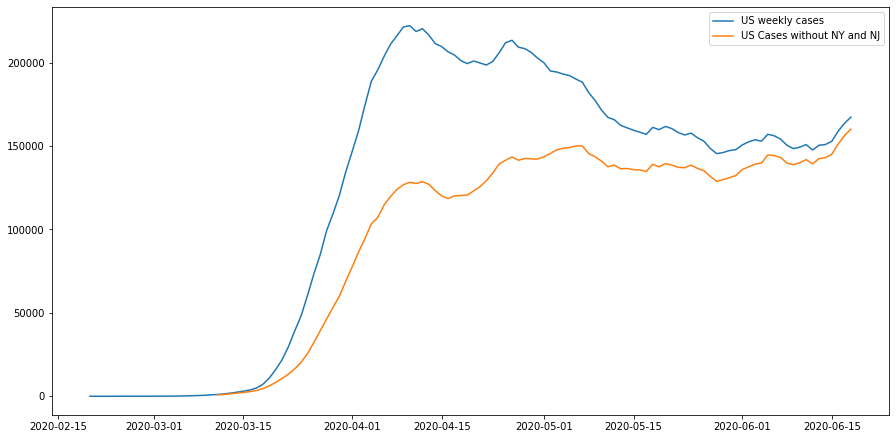

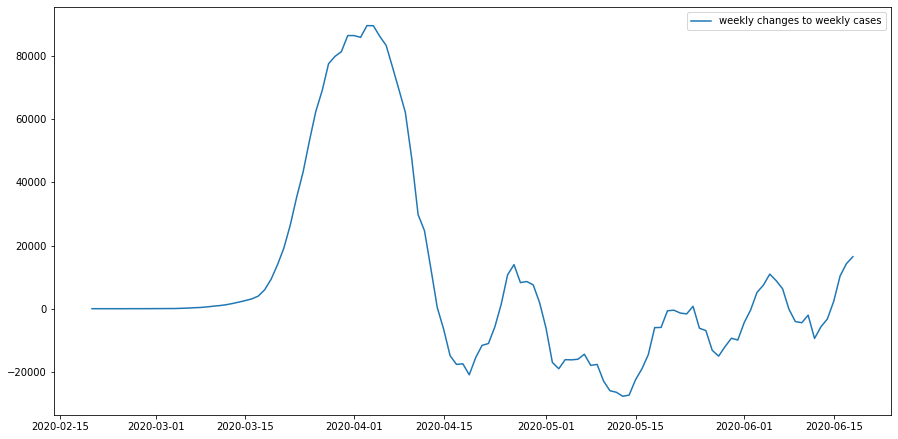

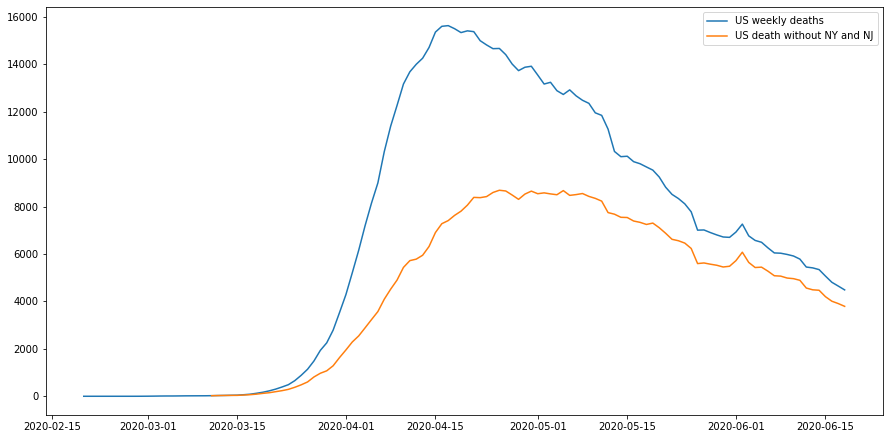

In [164]:
plt.figure(figsize = (15,7.5))
plt.plot(raw_US.cases.diff(7)[30:], label = "US weekly cases" )
plt.plot((raw_US.cases.diff(7) - (new_weekly_cases_state['New York'] + new_weekly_cases_state['New Jersey'] ))[30:], label = "US Cases without NY and NJ" )
#plt.plot(raw_Global['US'].diff(7), label = "Global" )
plt.legend()


plt.figure(figsize = (15,7.5))
plt.plot(raw_US.cases.diff(7).diff(7)[30:], label = "weekly changes to weekly cases" )
plt.legend()

plt.figure(figsize = (15,7.5))
plt.plot(raw_US.deaths.diff(7)[30:], label = "US weekly deaths")
plt.plot((raw_US.deaths.diff(7) - (new_weekly_deaths_state['New York'] + new_weekly_deaths_state['New Jersey'] ))[30:], label = "US death without NY and NJ" )
plt.legend()

['Arizona', 'Texas', 'Oregon', 'Florida', 'Nevada', 'Hawaii', 'Oklahoma', 'South Carolina', 'Wyoming', 'Alabama']
['Illinois', 'Massachusetts', 'Rhode Island', 'New Hampshire', 'New Jersey', 'Maryland', 'District of Columbia', 'Vermont', 'Virginia', 'Michigan']


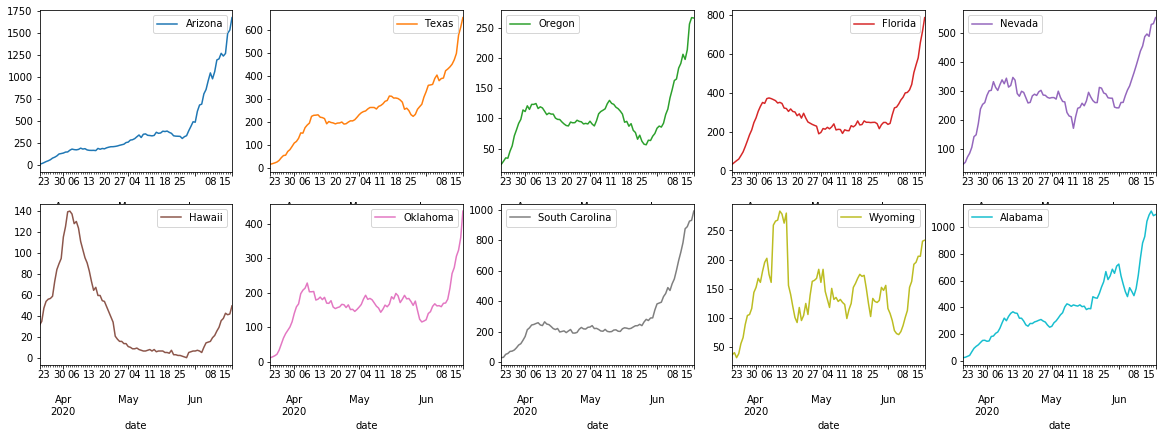

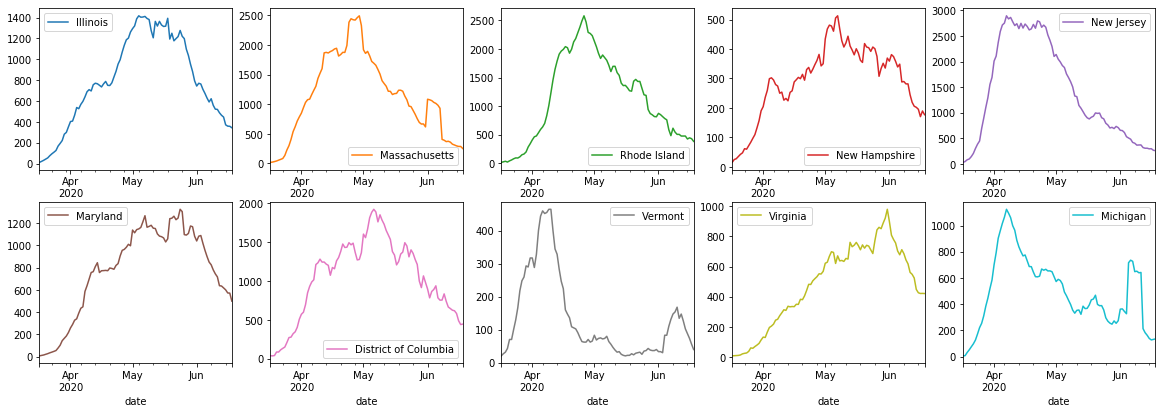

In [166]:
order = list(change_in_new_cases.values())
order.sort(reverse = True)
top_10_states = [key for key, value in change_in_new_cases.items() if value in order[:10] ]
bottom_states = [key for key, value in change_in_new_cases.items() if value in order[-10:]]
print(top_10_states)
print(bottom_states)

top_10 = pd.DataFrame()
bottom = pd.DataFrame()
for st in top_10_states:
    top_10[st] = new_cases_per_mil[st][-90:]
#    top_10[st] = new_weekly_cases_state[st]
for st in bottom_states:
    bottom[st] = new_cases_per_mil[st]
    
top_10.dropna(inplace = True)
top_10.plot(subplots = True, layout = (10,5), figsize = (20,35), sharex=False)

bottom.dropna(inplace = True)
bottom.plot(subplots = True, layout = (10,5), figsize = (20,35), sharex=False)
plt.show()
#top_10['Oregon'].plot(figsize = (10,7.5))

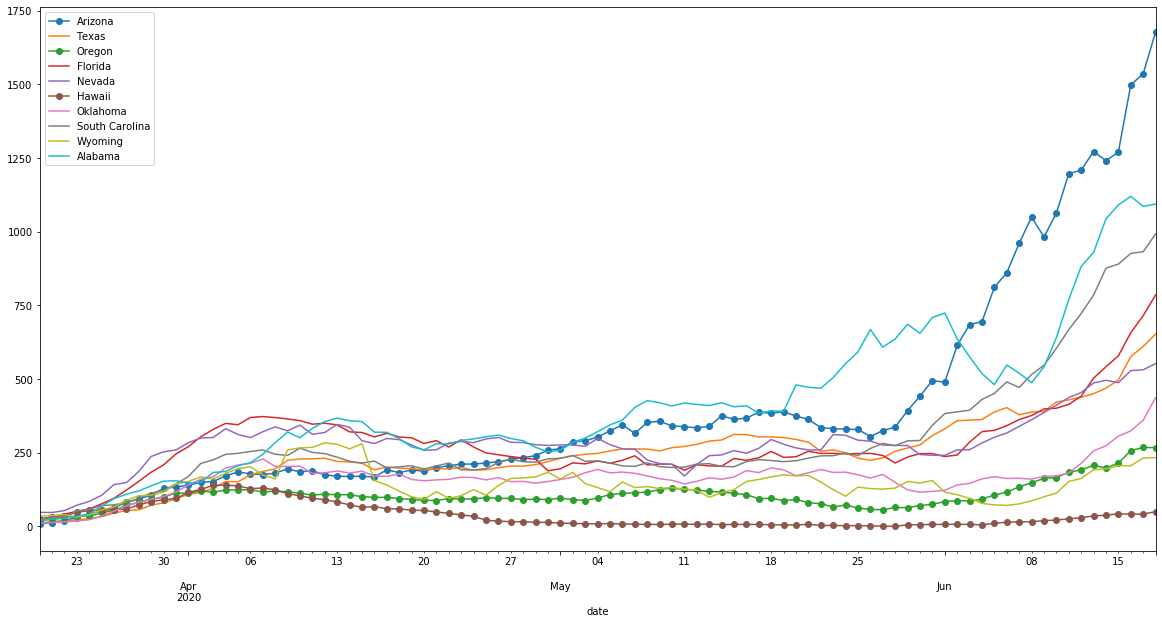

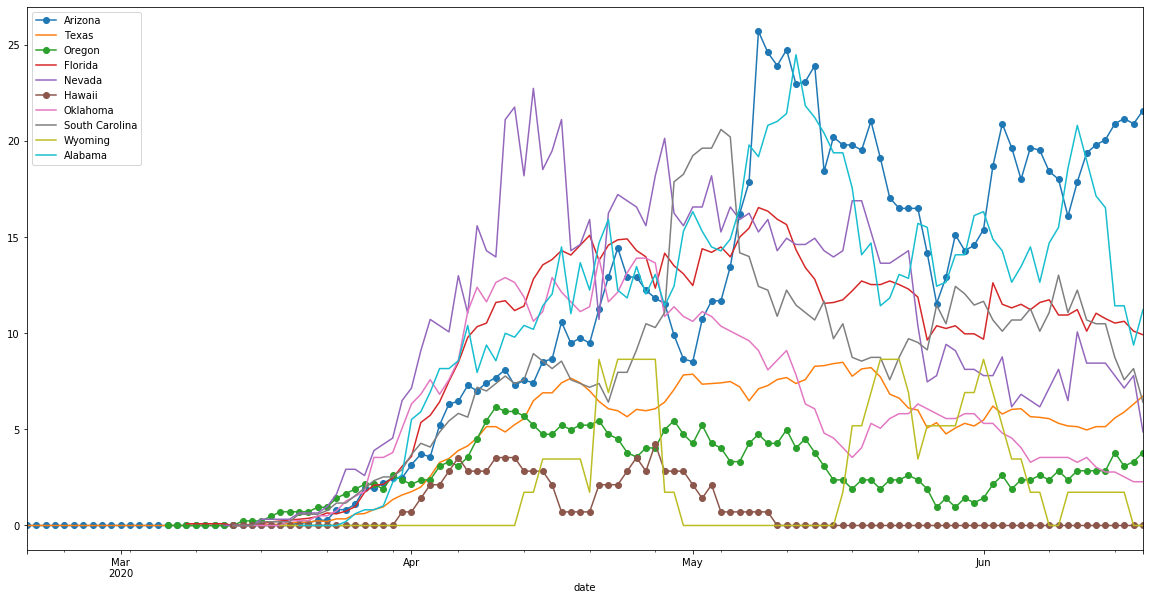

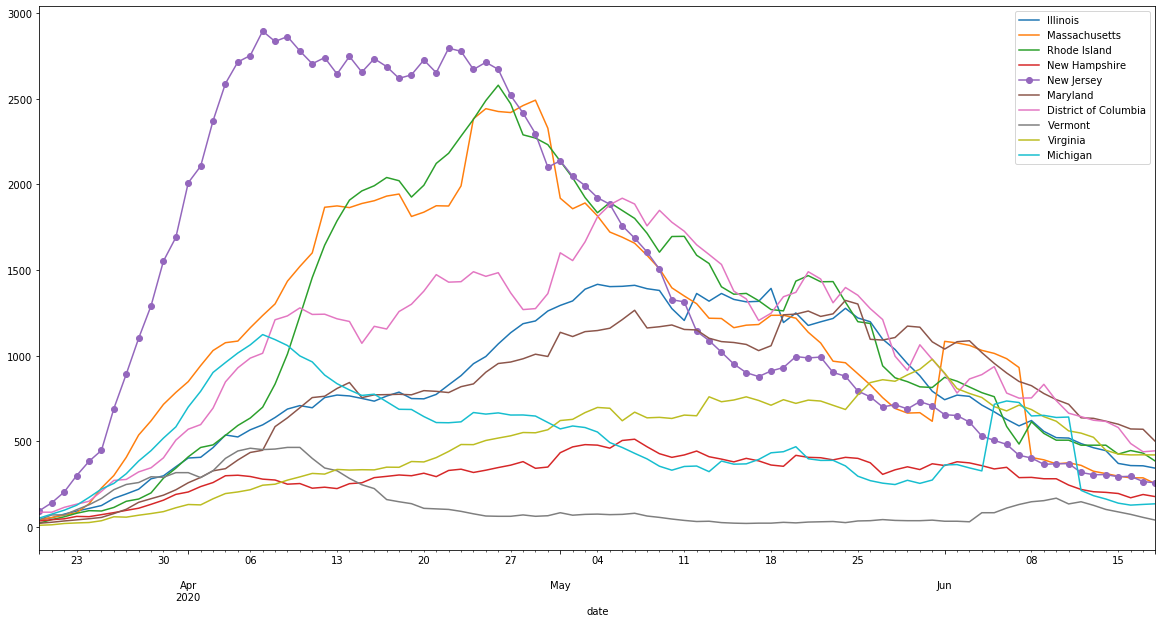

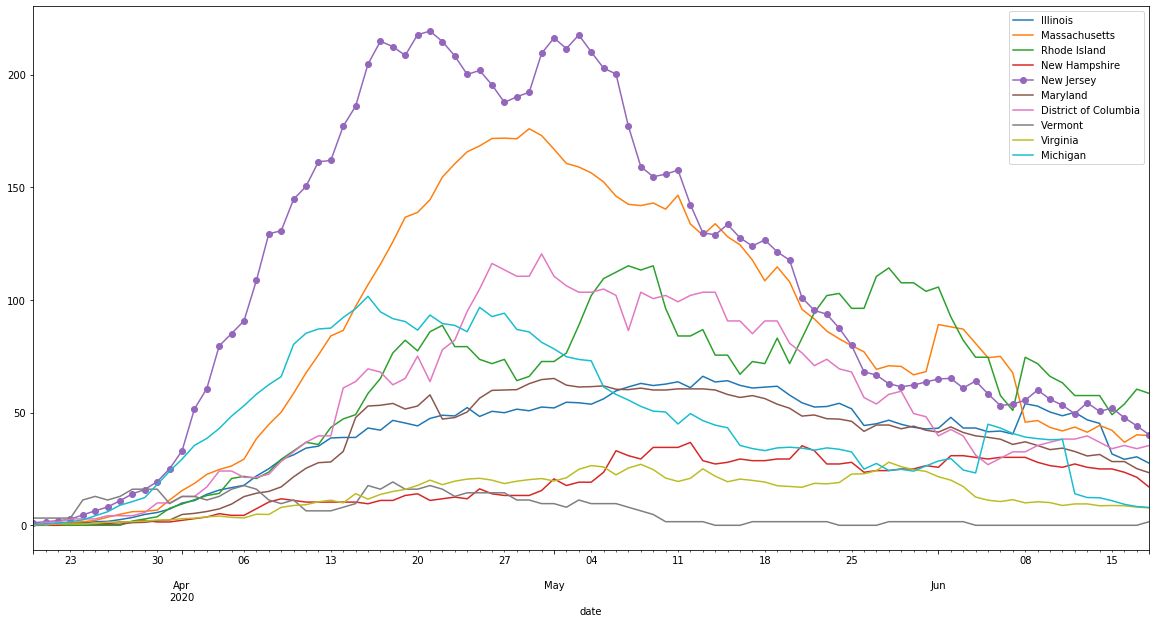

In [167]:
plt.figure(figsize = (20,10))
for st in top_10_states:
    if st == 'Hawaii' or st == 'Arizona' or st == 'Oregon' :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st, marker='o')
    else :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st )
plt.legend()

plt.figure(figsize = (20,10))
for st in top_10_states:
    if st == 'Hawaii' or st == 'Arizona' or st == 'Oregon':
        new_death_per_mil[st]['2020-02-20':].plot(label = st, marker='o')
    else :
        new_death_per_mil[st]['2020-02-20':].plot(label = st )
plt.legend()


plt.figure(figsize = (20,10))
for st in bottom_states:
    if st == 'New Jersey' or st == 'New York' :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st, marker='o')
    else :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st )
plt.legend()

plt.figure(figsize = (20,10))
for st in bottom_states:
    if st == 'New Jersey' or st == 'New York' :
        new_death_per_mil[st]['2020-03-20':].plot(label = st, marker='o')
    else :
        new_death_per_mil[st]['2020-03-20':].plot(label = st )

plt.legend()

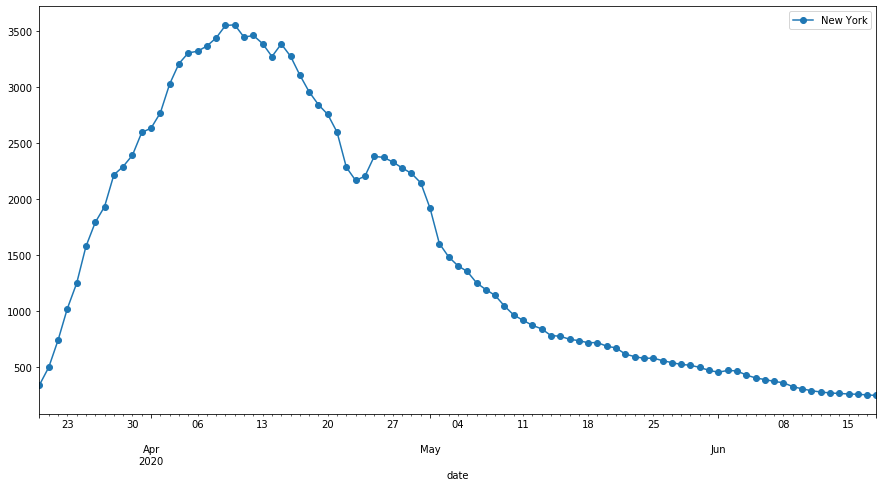

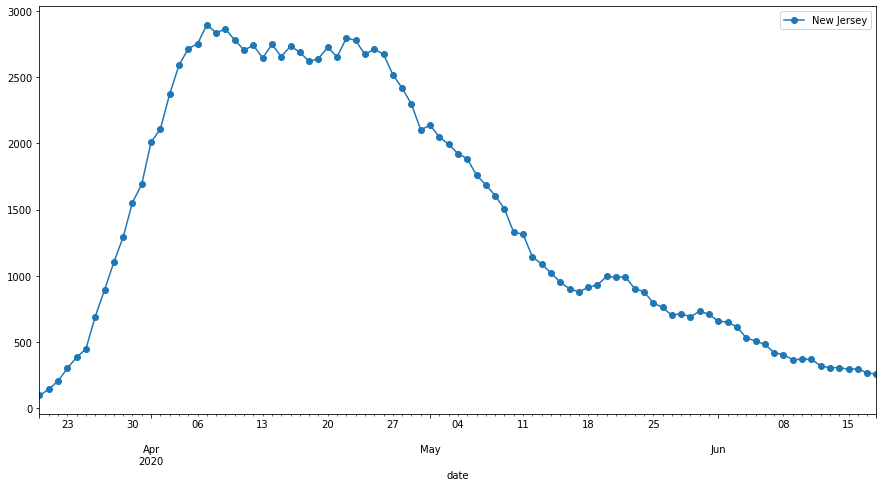

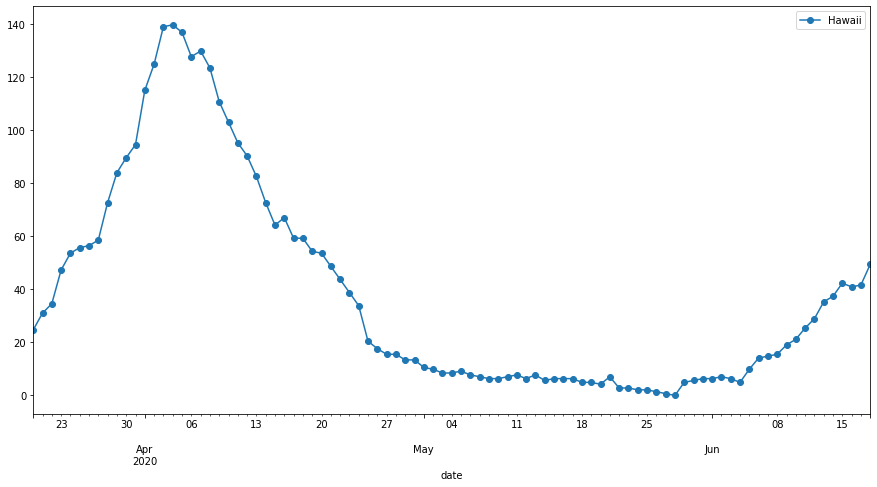

In [168]:
interested_state = ['New York', 'New Jersey', 'Hawaii']

for st in interested_state:
    plt.figure(figsize = (15,7.5))
    new_cases_per_mil[st]['2020-03-20':].plot(label = st, marker='o')
    plt.legend()



In [169]:
def start_of_pandemic(cases, ratio = -1, limit = -1):
    if limit == -1:
        return [ date for date, val in dict(cases).items() if val >= cases.max()/ratio ][0].date() + dt.timedelta(days = -1)
    else:
        return [ date for date, val in dict(cases).items() if val >= limit ][0].date() + dt.timedelta(days = -1)

for st, cases in new_cases_per_mil.items():
    cases.dropna(inplace = True)
    print(st, "\t", start_of_pandemic(cases, ratio = 3), 
          "\t", [ date for date, val in dict(cases).items() if val < cases.max()/3 ][-1].date() )

Washington 	 2020-03-22 	 2020-03-22
Illinois 	 2020-04-03 	 2020-06-18
California 	 2020-04-03 	 2020-04-03
Arizona 	 2020-06-01 	 2020-06-01
Massachusetts 	 2020-03-31 	 2020-06-18
Wisconsin 	 2020-04-04 	 2020-04-21
Texas 	 2020-04-08 	 2020-04-29
Nebraska 	 2020-04-22 	 2020-04-22
Utah 	 2020-04-04 	 2020-04-21
Oregon 	 2020-03-28 	 2020-06-03
Florida 	 2020-03-31 	 2020-06-02
New York 	 2020-03-23 	 2020-06-18
Rhode Island 	 2020-04-08 	 2020-06-18
Georgia 	 2020-03-28 	 2020-03-28
New Hampshire 	 2020-03-30 	 2020-06-16
North Carolina 	 2020-05-01 	 2020-05-09
New Jersey 	 2020-03-27 	 2020-06-18
Colorado 	 2020-03-26 	 2020-06-18
Maryland 	 2020-04-06 	 2020-04-06
Nevada 	 2020-03-27 	 2020-05-11
Tennessee 	 2020-03-30 	 2020-03-30
Hawaii 	 2020-03-22 	 2020-06-17
Indiana 	 2020-03-30 	 2020-03-30
Kentucky 	 2020-04-04 	 2020-04-04
Minnesota 	 2020-04-28 	 2020-04-28
Oklahoma 	 2020-04-01 	 2020-06-02
Pennsylvania 	 2020-03-30 	 2020-06-18
South Carolina 	 2020-05-30 	 2020-05-3

In [197]:
count_cases = raw_Global.sum().to_dict()
global_cases = list(count_cases.values())
global_cases.sort(reverse = True)
global_cases
countries = [key for key, value in count_cases.items() if value in global_cases[:10]]
for con in countries:
    print(con, '\t', round(count_cases[con]/1000000))

Brazil 	 23
China 	 11
France 	 13
Germany 	 13
Italy 	 17
Russia 	 18
Spain 	 17
Turkey 	 10
US 	 102
United Kingdom 	 16


In [183]:
type([])

list